In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm  import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn

from pytvision.transforms import transforms as mtrans
from pytvision import visualization as view

sys.path.append('../')
from torchlib.datasets.factory  import FactoryDataset 
from torchlib.datasets import Dataset, TripletsDataset

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
pathname = '~/.datasets'
pathname = os.path.expanduser( pathname )
name_dataset=FactoryDataset.ferp

print(pathname)
print(name_dataset)

/home/fernandez/.datasets
ferp


In [3]:
def visualizatedataset( data, num=25, imsize=(64,64,3), padding=1 ):    
    """
    Visualization data set
        @data: data loader 
        @num: number of images show
    """
    
    databatch = torch.zeros( [num, imsize[2], imsize[0], imsize[1]], dtype=torch.float32 )
    for i in range(num): 
        idx = i # np.random.randint( len(data) )
        databatch[i,...] = data[idx]['image']        
    grid = utils.make_grid( databatch , nrow= int(np.sqrt(num)), normalize=True, padding=padding )       
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [4]:
dataloader = Dataset(
    data=FactoryDataset.factory(pathname=pathname, name=name_dataset, subset=FactoryDataset.training, download=True ),
    num_channels=3,
    transform=transforms.Compose([
        mtrans.ToResize( (64, 64), resize_mode='square', padding_mode=cv2.BORDER_REFLECT_101 ),
        mtrans.ToTensor(),
        mtrans.ToNormalization(),
        ])
    )

print(len( dataloader.data.classes ))
print( dataloader.data.class_to_idx )

8
{'Neutral - NE': 0, 'Happiness - HA': 1, 'Surprise - SU': 2, 'Sadness - SA': 3, 'Anger - AN': 4, 'Disgust - DI': 5, 'Fear - FR': 6, 'Contempt - CO': 7}


['Neutral - NE', 'Happiness - HA', 'Surprise - SU', 'Sadness - SA', 'Anger - AN', 'Disgust - DI', 'Fear - FR', 'Contempt - CO']
101


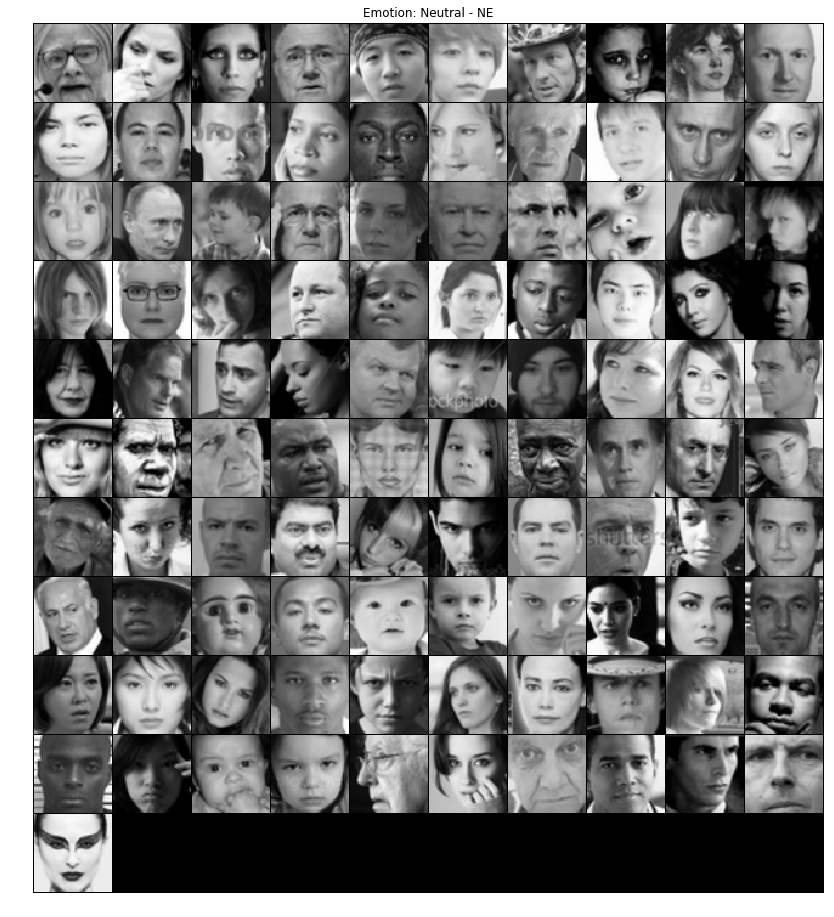

In [6]:
num=100
classes_select = 0
dataloader_select = []
k=0
labels = dataloader.labels
for i in range( len(dataloader) ):
    if labels[i] != classes_select: 
        continue        
    dataloader_select.append(dataloader[i]); k+=1
    if k > num: break;

n = len(dataloader_select)

print(dataloader.data.classes)
print(n)

plt.figure( figsize=(16,16))
visualizatedataset(dataloader_select, num=n, imsize=(64,64,3) )
plt.title('Emotion: {}'.format( dataloader.data.classes[ classes_select ] ) )
plt.axis('off')
plt.ioff()
plt.show() 

100
10
Batch: 0 dict_keys(['a', 'b', 'c'])
Reset dataloader ...


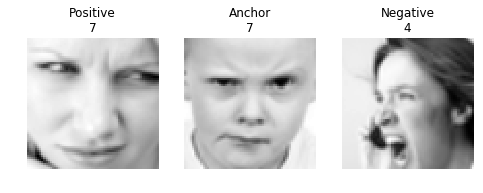

Batch: 1 dict_keys(['a', 'b', 'c'])
Reset dataloader ...


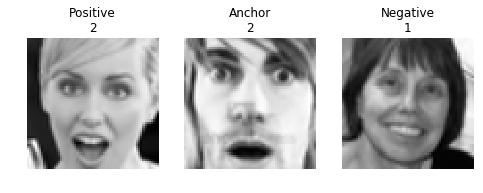

Batch: 2 dict_keys(['a', 'b', 'c'])
Reset dataloader ...


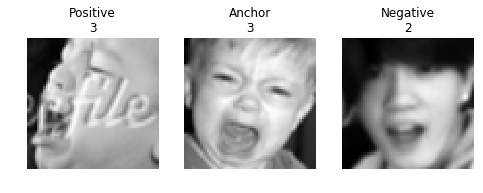

Batch: 3 dict_keys(['a', 'b', 'c'])
Reset dataloader ...


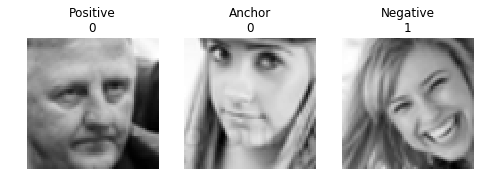

Batch: 4 dict_keys(['a', 'b', 'c'])
Reset dataloader ...


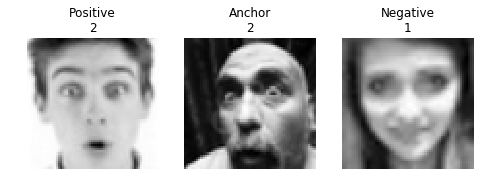

In [6]:
size_input=64
triplet_size_train=1000

# transformations 
normalize = mtrans.ToMeanNormalization(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )


transforms_data = transforms.Compose([
    #mtrans.ToResize( (size_input, size_input), resize_mode='crop' ) ,
    mtrans.ToResize( (size_input, size_input), resize_mode='square', padding_mode=cv2.BORDER_REPLICATE ) ,
    mtrans.ToTensor(),
    mtrans.ToWhiteNormalization(),
    ])


data = TripletsDataset(
    data=FactoryDataset.factory(
        pathname=pathname, 
        name=name_dataset, 
        subset=FactoryDataset.training, 
        download=False ),
    num_channels=3,
    n_triplets=triplet_size_train,
    transform=transforms_data
    )

dataloader = DataLoader(data, batch_size=10, shuffle=False, num_workers=2  )

print( len(dataloader) )
print( dataloader.batch_size )

for i_batch, sample_batched in enumerate(dataloader):        
    print('Batch: {} {}'.format(i_batch, sample_batched.keys()) )

    a = sample_batched['a']
    b = sample_batched['b']
    c = sample_batched['c']

    # a positive
    # b anchor
    # c negativo
    
    img1 = a['image'].numpy(); lab1 = a['label'].numpy()
    img2 = b['image'].numpy(); lab2 = b['label'].numpy()
    img3 = c['image'].numpy(); lab3 = c['label'].numpy()

    lab1 = np.argmax(lab1)
    lab2 = np.argmax(lab2)
    lab3 = np.argmax(lab3)

    # observe 4th batch and stop.


    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,4), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(img1[0,...].transpose( (1,2,0) ) )
    ax1.set_title('Positive\n{}'.format(lab1))
    ax1.set_adjustable('box-forced')

    ax2.axis('off')
    ax2.imshow(img2[0,...].transpose( (1,2,0) ) )
    ax2.set_title('Anchor\n{}'.format(lab2))
    ax2.set_adjustable('box-forced')

    ax3.axis('off')
    ax3.imshow(img3[0,...].transpose( (1,2,0) ) )
    ax3.set_title('Negative\n{}'.format(lab3))
    ax3.set_adjustable('box-forced')
    
    
    dataloader.dataset.reset()

    plt.show()

    if i_batch == 4:
        break
        
   